In [1]:
from jax_circuits import *
from scipy.stats import unitary_group
import matplotlib.pyplot as plt

import time
import pickle

from qiskit import transpile
from qiskit.quantum_info import Operator

from topology import *

from jax import custom_jvp, jvp, grad
from jax.scipy.optimize import minimize

# How many local minimums are there?

## Helper functions

In [28]:
def learning_success_rate(u_func, u_target, n_angles, n_samples, key, **kwargs):
    initial_angles = random.uniform(key, shape=(n_samples, n_angles), minval=0, maxval=2*jnp.pi)
    angles_and_loss_histories = gradient_descent_learn(u_func, u_target, n_angles,
                                                      initial_angles=initial_angles, **kwargs)
    
    best_losses = [min(hist) for (_, hist) in angles_and_loss_histories]
    return angles_and_loss_histories, len([loss for loss in best_losses if loss<kwargs['target_disc']])/len(best_losses)

def chart_learning_success_rate(n_qubits, key, n_samples=20, min_depth=0, max_depth=0, **kwargs):

    success_rates = []
    for n in range(min_depth, max_depth+1):
        a = Ansatz(n_qubits, 'cz', fill_layers(sequ_layer(n_qubits), n))
        key, subkey = random.split(key)
        target_angles = random.uniform(subkey, shape=(a.n_angles, ), minval=0, maxval=2*jnp.pi)
        u_target = a.unitary(target_angles)
        
        key, subkey = random.split(key)
        _, rate = learning_success_rate(a.unitary, u_target, a.n_angles, n_samples, subkey, **kwargs)
        success_rates.append(rate)
        
    return success_rates

### 2-qubit

In [5]:
%%time
max_depth = TLB(2)+3
key, subkey = random.split(key)
success_rates = chart_learning_success_rate(2, subkey, n_samples=20, 
                                            max_depth=max_depth,
                                            target_disc=1e-3)
with open('success_rates_2.pickle', 'wb') as f:
     pickle.dump(success_rates, f)

CPU times: user 47.4 s, sys: 2.09 s, total: 49.5 s
Wall time: 44.1 s


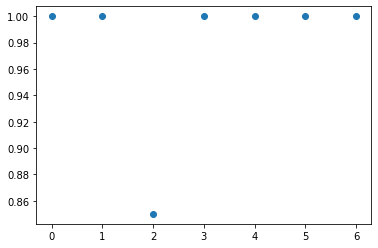

In [14]:
max_depth = TLB(2)+3
with open('success_rates_2.pickle', 'rb') as f:
     success_rates = pickle.load(f)
        
plt.scatter(range(max_depth+1), success_rates)

### 3-qubit

In [15]:
%%time
max_depth = TLB(3)+2
key, subkey = random.split(key)
success_rates = chart_learning_success_rate(3, subkey, n_samples=20, 
                                            max_depth=max_depth,
                                            target_disc=1e-3)
with open('success_rates_3.pickle', 'wb') as f:
     pickle.dump(success_rates, f)

CPU times: user 13min 54s, sys: 45.5 s, total: 14min 39s
Wall time: 12min 4s


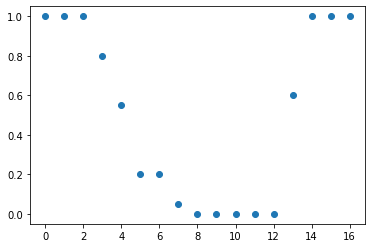

In [16]:
max_depth = TLB(3)+2
with open('success_rates_3.pickle', 'rb') as f:
     success_rates = pickle.load(f)
        
plt.scatter(range(max_depth+1), success_rates)

As the plot above shows, GD appears to get stuck in local minimums a lot in the depth range 7-12. Let us zoom in on this region.

In [29]:
%%time
min_depth = 7
max_depth = 12
key, subkey = random.split(key)
success_rates = chart_learning_success_rate(3, subkey, n_samples=100, 
                                            min_depth=min_depth,
                                            max_depth=max_depth,
                                            target_disc=1e-3)
with open('success_rates_3_zoom.pickle', 'wb') as f:
     pickle.dump(success_rates, f)

CPU times: user 36min 42s, sys: 2min 14s, total: 38min 57s
Wall time: 30min 42s


[0.1, 0.01, 0.0, 0.0, 0.0, 0.01]


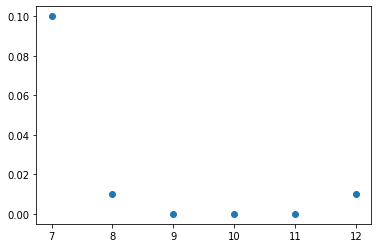

In [33]:
min_depth = 7
max_depth = 12
with open('success_rates_3_zoom.pickle', 'rb') as f:
     success_rates = pickle.load(f)

print(success_rates)
plt.scatter(range(min_depth, max_depth+1), success_rates)

OK, seems that another zoom-in is in order. Let's just do depth=10 which seems to be the most difficult.

In [39]:
%%time
key, subkey = random.split(key)
chart_learning_success_rate(3, subkey, n_samples=1000, 
                                            min_depth=10,
                                            max_depth=10,
                                            n_iterations=2000,
                                            target_disc=1e-3)

CPU times: user 26min 53s, sys: 1min 50s, total: 28min 44s
Wall time: 23min 36s


[0.0]

In [40]:
%%time
key, subkey = random.split(key)
chart_learning_success_rate(3, subkey, n_samples=1000, 
                                            min_depth=9,
                                            max_depth=9,
                                            n_iterations=2000,
                                            target_disc=1e-3)

CPU times: user 30min 33s, sys: 2min 10s, total: 32min 44s
Wall time: 28min 55s


[0.002]

Let us also check directly the success rate for the toffoli gate.

In [26]:
%%time
qc = QuantumCircuit(3)
qc.ccx(0, 1, 2)
u_toff3 = Operator(qc.reverse_bits()).data

placements_toff3 = [[1, 2], [0, 2], [1, 2], [0, 2], [0, 1], [0, 1]]
a_toff3 = Ansatz(3, 'cz', placements={'free': placements_toff3})

key, subkey = random.split(key)
_, rate_toff3 = learning_success_rate(a_toff3.unitary, u_toff3, a_toff3.n_angles, 50, subkey,
                                     target_disc=1e-4)
rate_toff3

CPU times: user 2min 47s, sys: 10.3 s, total: 2min 57s
Wall time: 2min 23s


0.12

## 4-qubit

In [41]:
%%time
max_depth = TLB(4)+2
key, subkey = random.split(key)
success_rates = chart_learning_success_rate(4, subkey, n_samples=20, 
                                            max_depth=max_depth,
                                            target_disc=1e-3)
with open('success_rates_4.pickle', 'wb') as f:
     pickle.dump(success_rates, f)

CPU times: user 1h 52min 44s, sys: 3min 32s, total: 1h 56min 17s
Wall time: 1h 26min 25s


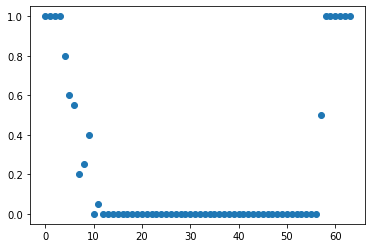

In [43]:
max_depth = TLB(4)+2
with open('success_rates_4.pickle', 'rb') as f:
     success_rates = pickle.load(f)
        
plt.scatter(range(max_depth+1), success_rates)